# Session 6- Logistic Regression on Employee turnover(churn) data

<p>The following notebook provides an example code of analyzing <b>Employee turnover(churn)</b> using logistic regression. The dependent variable is <b>Churn (1-yes, 0-no)</b>. 
    
<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis](#pandas)
2. [Modelling (creating dummies, train test split)](#select)
3. [Logistic regression construction and interpretation (log odds, marginal effects)](#stats)
4. [Model evaluation(confusion matrix,classification report)](#stats1) 

 <h2>1.Descriptive analysis</h2> <a name="pandas"></a>

The initial data consists of 14999 observations of 10 variables.There are 3008 duplicates in data, however we will Not drop them, as there is no employee ID or some uniquely defined variable using which we can identify each employee. In short, there might be just people having similar postitions, salary etc.  Data overview hints that there are continuous (satisfaction_level,last_evaluation,average_montly_hours etc.), binary(promotion_last_5years,work_accident) and categorical (department, salary) features.
Employee churn is not evenly balanced between 0s and 1s. As the countplot and value counts show, only about 23% of employees are leaving and ~76% are staying.So we can use this info as a naive assumption for newcomers to decide whether they'll leave or stay. In other words, if the resulting score is more than the noted value, then our model will be not bad, otherwise-a bad one.

We also outlined several questions answers of can be observed visually.

    -Is there a relationship between satisfaction level, salary and churn?
    -What is the salary rate distribution by departments?
    -Which departments have the highest/lowest churn rate?
The visualization shows that employee churn is connected with the satisfaction level. The boxplot shows that employees who left are on average less satisfied with the job, regardless of the salary.
The highest paid department is management and it is also the one having highest staying rate. The lowest salary rate is at support department. HR is the department having hisghest churn rate.

In case of logistic regression when constructing a heatmap we are mostly interested in identifying correlations between independent variables, as the target is binary and correlation between Y and X-s is not represenative in this case.
The highest correlation is between average montly hours and number of projects (corr. coefficient is 0.42), which is logical as the more projects there are, the more time you spend for their implementation. Next comes number of projects and last evaluation, with 0.35 correlation 
coefficient.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score, roc_auc_score

In [2]:
#importing the data and making a dataframe
url="https://raw.githubusercontent.com/srbuhimirzoyan/Business_Analytics_Spring2020/master/Session_6_turnover_data.csv"
data=pd.read_csv(url)

In [3]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
work_accident            14999 non-null int64
churn                    14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
#have a look at first rows of the dataframe
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,churn,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,churn,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 3008
Missing values: 0
Single valued columns: Index([], dtype='object')


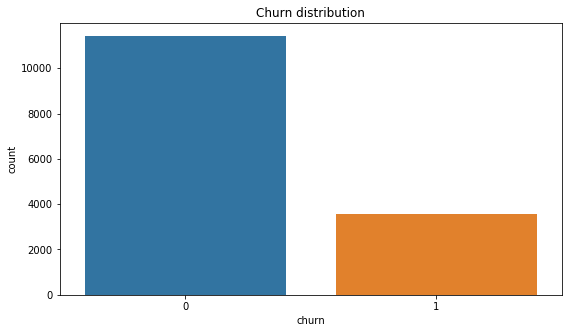

In [7]:
#let's visualise the distribution of churn
plt.figure(figsize=(9,5))
sns.countplot(data.churn)
plt.title("Churn distribution")
plt.show()

In [8]:
#lets count the benchmark for employee churn
data.churn.value_counts(normalize=True).mul(100).rename("churn percentage")

0    76.191746
1    23.808254
Name: churn percentage, dtype: float64

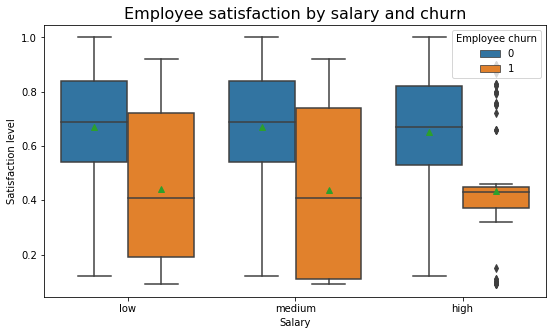

In [9]:
#Let's see the relationship of salary and satisfaction level
plt.figure(figsize=(9,5))
sns.boxplot(x="salary", y="satisfaction_level", data=data, showmeans=True, hue="churn")
plt.legend(title='Employee churn', loc='upper right')
plt.xlabel("Salary")
plt.ylabel("Satisfaction level")
plt.title("Employee satisfaction by salary and churn",fontdict={"fontsize":16})
plt.show()


In [10]:
#creating churn rate and salary rate
#data using groupby. parameter: "normalize"in value_counts() returns relative frequencies, "mul" multiplies by noted number
#(in this case-100,to get %)
churn_rate=data.groupby("department")["churn"].value_counts(normalize=True).rename("percentage").mul(100).reset_index()
salary_rate=data.groupby("department")["salary"].value_counts(normalize=True).rename("percentage").mul(100).reset_index()

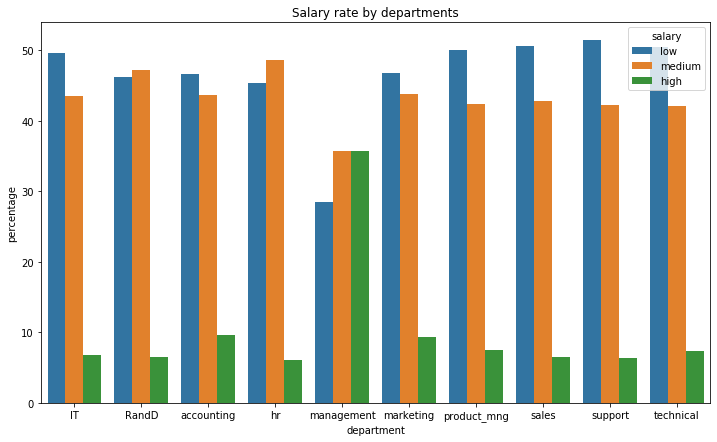

In [11]:
plt.figure(figsize=(12,7))
sns.barplot(x="department", y="percentage", hue="salary", data=salary_rate)
plt.title("Salary rate by departments")
plt.show()

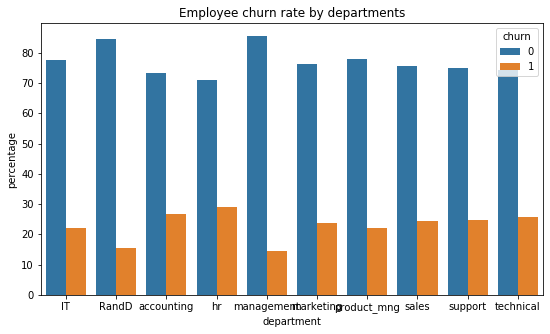

In [12]:
plt.figure(figsize=(9,5))
sns.barplot(x="department",y="percentage", hue="churn",data=churn_rate)
plt.title("Employee churn rate by departments")
plt.show()

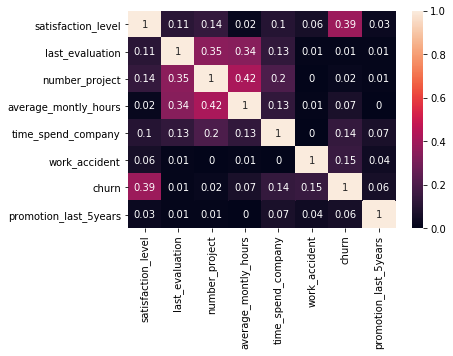

In [13]:
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

<h1> 2. Modelling (creating dummies, train test split)</h1> <a name="select"> </a>

We dummify the categorical variables, separate X and Y and split the data into train and test sets

In [14]:
#Let's create dummy variables 
data=pd.get_dummies(data,drop_first=True)

In [15]:
#separating X and Y
Y=data["churn"]
X=data.drop("churn",axis=1)

In [16]:
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X=sm.add_constant(X)

C:\Users\Srbuhi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
#let's split X and Y data into test and train datasets, test data is 25% of overall data
#splitting the data into train and test sets
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

<h1> 3. Logistic regression construction and interpretation (log odds, marginal effects)</h1> <a name="stats"> </a>

We will construct the model based on statsmodels.api library, meaning will fit the data on training set and evaluate both 
for training and testing sets.

In [18]:
#constructing the logit model
model=Logit(Y0,X0)
#fitting the model
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.426662
         Iterations 7


In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                11249
Model:                          Logit   Df Residuals:                    11230
Method:                           MLE   Df Model:                           18
Date:                Sat, 04 Apr 2020   Pseudo R-squ.:                  0.2220
Time:                        21:32:06   Log-Likelihood:                -4799.5
converged:                       True   LL-Null:                       -6169.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.6772      0.220     -7.622      0.000      -2.108      -1.246
satisfaction_level        -4.1914      0.114    -36.915      0.000      -4.414      -3.969
last_evaluation            0.6789      0.172      3.936      0.000       0.341       1.017
number_project            -0.3066      0.025    -12.480      0.000      -0.355      -0.258
average_montly_hours       0.0047      0.001      7.820      0.000       0.004       0.006
time_spend_company         0.2646      0.018     14.683      0.000       0.229       0.300
work_accident             -1.5052      0.103    -14.657      0.000      -1.706      -1.304
promotion_last_5years     -1.3486      0.290     -4.649      0.000      -1.917      -0.780
department_RandD          -0.5731      0.161     -3.556      0.000      -0.889      -0.257
department_accounting      0.1222      0.141      0.864      0.388      -0.155       0.400
department_hr              0.4125      0.142      2.912      0.004       0.135       0.690
department_management     -0.2649      0.172     -1.541      0.123      -0.602       0.072
department_marketing       0.2000      0.141      1.414      0.157      -0.077       0.477
department_product_mng     0.0736      0.136      0.540      0.590      -0.194       0.341
department_sales           0.1398      0.103      1.355      0.175      -0.062       0.342
department_support         0.1817      0.113      1.610      0.107      -0.039       0.403
department_technical       0.2437      0.109      2.239      0.025       0.030       0.457
salary_low                 1.9639      0.151     13.028      0.000       1.668       2.259
salary_medium              1.4705      0.152      9.704      0.000       1.173       1.767
==========================================================================================
"""

- <b> For a one-unit increase in satisfaction_level we expect on average a 4.1914 decrease in the log-odds of churn, holding all other independent variables constant.</b>
- <b> For employees with low salaries, we expect on average a 1.9639 increase in the log-odds of the dependent variable churn compared to the employees with high salaries.</b>

As we want to interpret probabilites, let's get marginal effects.

In [20]:
results.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  churn
Method:                          dydx
At:                           overall
==========================================================================================
                            dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
satisfaction_level        -0.5748      0.012    -48.250      0.000      -0.598      -0.551
last_evaluation            0.0931      0.024      3.944      0.000       0.047       0.139
number_project            -0.0420      0.003    -12.712      0.000      -0.049      -0.036
average_montly_hours       0.0006   8.14e-05      7.892      0.000       0.000       0.001
time_spend_company         0.0363      0.002     15.133      0.000       0.032       0.041
work_accident             -0.2064      0.014    -15.043      0.000      -0.233      -0.180
promotion_last_5years     -0.1849      0.040     -4.660      0.000      -0.263      -0.107
department_RandD          -0.0786      0.022     -3.562      0.000      -0.122      -0.035
department_accounting      0.0168      0.019      0.864      0.388      -0.021       0.055
department_hr              0.0566      0.019      2.916      0.004       0.019       0.095
department_management     -0.0363      0.024     -1.542      0.123      -0.083       0.010
department_marketing       0.0274      0.019      1.414      0.157      -0.011       0.065
department_product_mng     0.0101      0.019      0.540      0.589      -0.027       0.047
department_sales           0.0192      0.014      1.355      0.175      -0.009       0.047
department_support         0.0249      0.015      1.611      0.107      -0.005       0.055
department_technical       0.0334      0.015      2.240      0.025       0.004       0.063
salary_low                 0.2693      0.020     13.292      0.000       0.230       0.309
salary_medium              0.2017      0.021      9.802      0.000       0.161       0.242
==========================================================================================
"""

- <b> An Incremental increase in satisfaction level will decrease the probability of churn on average by 57.48% when other factors are held constant.</b>
- <b>Employees with low salary have on average 26.93% higher probability of churn compared to employees with high salaries.</b>

<h1> 3. Model evaluation(confusion matrix,classification report)</h1> <a name="stats1"> </a>

In order to evaluate the model, we will use several methods. First,we will calculate classification metrics by hand. For that purpose we will use confusion matrix based on <code>pred_table()</code> to observe the different results of predictions based on the threshold.
Next, we will use <code> confusion_matrix()</code> from sklearn library, to make calculations easier.
Last, we will use classification report.
Note that in order to calculate the metrics for test data we will need:
   - to predict probabilities for test data,
   - based on the predicted probabilities to classify observations into "1" and "0",
   - construct confusion matrix for the predicted classes and true values of dependent variables

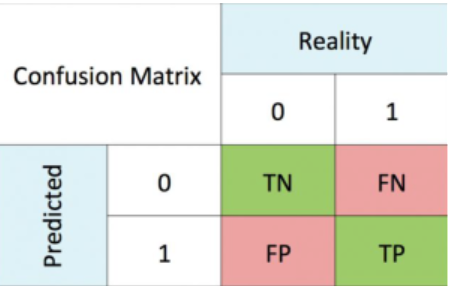

<b> Precision=TP/TP+FP</b> Out of all the positive classes we have predicted correctly, how many are actually positive.

<b>Recall(Sensitivity)=TP/TP+FN </b>  Out of all the positive classes, how much we predicted correctly.

<b>Specificity=TN/TN+FP </b>  Out of all the positive classes, how much we predicted correctly.

<b>F1 Score:</b>This is a harmonic mean (2xPrecisionxRecall/Precision+Recall) of the true positive rate (recall) and precision. 

<b>*NOTE*:</b> We use `probabilities` for ROC_AUC score calculation and `classes` for accuracy, recall, specificity.

In [21]:
#default treshold is 0.5, T is for transposing the matrix
results.pred_table().T

array([[7965., 1739.],
       [ 610.,  935.]])

In [22]:
#let's change treshold from 0.5 to 0.7
results.pred_table(0.7).T

array([[8367., 2312.],
       [ 208.,  362.]])

It can be seen that after changing treshold, we predicted more 0 (8367) and less 1 (362).

In [23]:
#let's calculate overall accuracy, recall and specificity by hand for the train set
Accuracy=(7965+935)/(7965+1739+610+935)
Recall=935/(935+1739)
Specificity=7965/(7965+610)
print("Accuracy:",Accuracy)
print("Recall:",Recall)
print("Specificity:",Specificity)

Accuracy: 0.7911814383500756
Recall: 0.34966342557965596
Specificity: 0.928862973760933


In [24]:
#now let's make everything easier
#predicting for train and test data
Y1_hat=results.predict(X1)
Y0_hat=results.predict(X0)

In [25]:
#converting probabilities into labels
Y1_class=np.where(Y1_hat>=0.5,1,0)
Y0_class=np.where(Y0_hat>=0.5,1,0)

In [26]:
#Using confusion matrix for train and test data
cm_train=confusion_matrix(Y0,Y0_class).T

In [27]:
#let's calculate overall accuracy, recall and specificity for train data
print("Accuracy_train:", (cm_train[0,0]+cm_train[1,1])/len(Y0))
print("Sensitivity_train:",cm_train[1,1]/(cm_train[1,1]+cm_train[0,1]))
print("Specificity_train:",cm_train[0,0]/(cm_train[0,0]+cm_train[1,0]))

Accuracy_train: 0.7911814383500756
Sensitivity_train: 0.34966342557965596
Specificity_train: 0.928862973760933


In [28]:
#confusion matrix for the test data
cm_test=confusion_matrix(Y1,Y1_class).T

In [29]:
#let's calculate overall accuracy, recall and specificity for test data
print("Accuracy_test:", (cm_test[0,0]+cm_test[1,1])/len(Y1))
print("Sensitivity_test:",cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]))
print("Specificity_test:",cm_test[0,0]/(cm_test[0,0]+cm_test[1,0]))


Accuracy_test: 0.7850666666666667
Sensitivity_test: 0.34002229654403565
Specificity_test: 0.9249912372940764


In [30]:
#calculating using classification report
print("Logistic Regression Train:")
print(classification_report(Y0,Y0_class))

print("Logistic Regression Test:")
print(classification_report(Y1,Y1_class))

Logistic Regression Train:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      8575
           1       0.61      0.35      0.44      2674

    accuracy                           0.79     11249
   macro avg       0.71      0.64      0.66     11249
weighted avg       0.77      0.79      0.77     11249

Logistic Regression Test:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2853
           1       0.59      0.34      0.43       897

    accuracy                           0.79      3750
   macro avg       0.70      0.63      0.65      3750
weighted avg       0.76      0.79      0.76      3750



We can see that although the metrics are good for 0s, our model is not doing a good job when predicting 1s. This may be a problem 
of unbalanced data, not using cross-validation and hyperparameter tuning.

In [31]:
#Note that we can also calculate accuracy, recall and ROC_AUC score using respective metrics from sklearn library
#summarizing the results into a dataframe
results_summary=pd.DataFrame({"Accuracy":[accuracy_score(Y0,Y0_class),accuracy_score(Y1,Y1_class)],
                              "ROC_AUC":[roc_auc_score(Y0,Y0_hat),roc_auc_score(Y1, Y1_hat)],
                              "Recall":[recall_score(Y0, Y0_class),recall_score(Y1, Y1_class)]
                              },
                             index=["Training set","Testing set"])
results_summary



,Accuracy,ROC_AUC,Recall
Training set,0.791181,0.821893,0.349663
Testing set,0.785067,0.818762,0.340022


You can note the difference between accuracy and ROC AUC score: Accuracy is much higher than ROC AUC, conditioned by not balanced 
data. ROC AUC score is lower as it is based on all levels of thresholds (not just 0.5), and takes into account both recall and
specificity score values.